In [2]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
def get_intervals(labels):
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append((label, i, j))
            i = j
            label = labels[j]

    intervals.append((label, i, l))

    return intervals

In [89]:
def extract_features(signal, n = 5):
    coeffs = fft.fft(signal)

    l = len(coeffs)
    freqs = fft.fftfreq(l)
    amps = np.abs(coeffs)
    
    l //= 2
    amps = amps[0 : l]
    freqs = freqs[0 : l]
   
    p = amps.argsort()
    freqs = freqs[p]
    amps = amps[p]

    features = []
    
    j = 0
    while j < n:
        if j < l:
            j += 1
        features.append([amps[l-j], abs(freqs[l-j])])

    return features

In [5]:
def convert_to_1d_array(data_2d):
    data_1d = []
    
    for point in data_2d:
        data_1d.append(point[0])
        
    return np.array(data_1d)

In [6]:
def get_signal_sample_features(signal, labels, n = 5, sampling_rate = 700, window_len = 30):
    samples = (sampling_rate*window_len)
    
    baseline_av = 0
    intervals = get_intervals(labels)

    sample_features = {
        1 : [],
        2 : [],
        3 : [],
        4 : []
    }

    for interval in intervals :
        label = interval[0]
        beg = interval[1]
        end = interval[2]

        if label > 4 :
            continue
    
        part_of_signal = signal[beg : end]

        if label == 0 :
            baseline_av = np.mean(part_of_signal)
            continue
        
        part_of_signal -= baseline_av
        
        l = len(part_of_signal)

        while l > 0 :
            sub_part = part_of_signal[max(0, l-samples) : l]
            l -= samples // 2

            features = extract_features(sub_part, n)
            sample_features[label].append(features)

    return sample_features

In [7]:
def get_subject(s_no) :
    path = '../WESAD/S' + str(s_no) + '/S' + str(s_no) + '.pkl'
    subject = pd.read_pickle(path)

    return subject

In [17]:
ref = {
    1 : 'Baseline',
    2 : 'Stress',
    3 : 'Amusement',
    4 : 'Meditation'
}

In [8]:
def convert_to_df(sample_features):
    global ref
    df = pd.DataFrame(columns=['label', 'amp', 'freq'])
    for label in sample_features :
        for points in sample_features[label] :
            for point in points :
                df = df.append({
                    'label' : ref[label],
                    'amp' : point[0],
                    'freq' : point[1]
                }, ignore_index=True)

    return df

In [9]:
def get_chest_sample_features(subject) :
    chest_signals = subject['signal']['chest']
    labels = subject['label']

    signal_features = {}
    for signal_type in chest_signals :
        if signal_type == 'ACC' :
            continue
        
        signal = convert_to_1d_array(chest_signals[signal_type])
        sample_features = get_signal_sample_features(signal, labels)

    return sample_features

In [1]:
subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

global_chest_signal_features = {}

for subject in subjects :
    subject= get_subject(2)
    chest_signal_features = get_chest_sample_features(subject)

    for signal_type in chest_signal_features :
        if signal_type not in global_chest_signal_features :
            global_chest_signal_features[signal_type] = chest_signal_features[signal_type]
            continue

        global_chest_signal_features[signal_type] = global_chest_signal_features[signal_type].append(chest_signal_features[signal_type])

NameError: name 'get_subject' is not defined

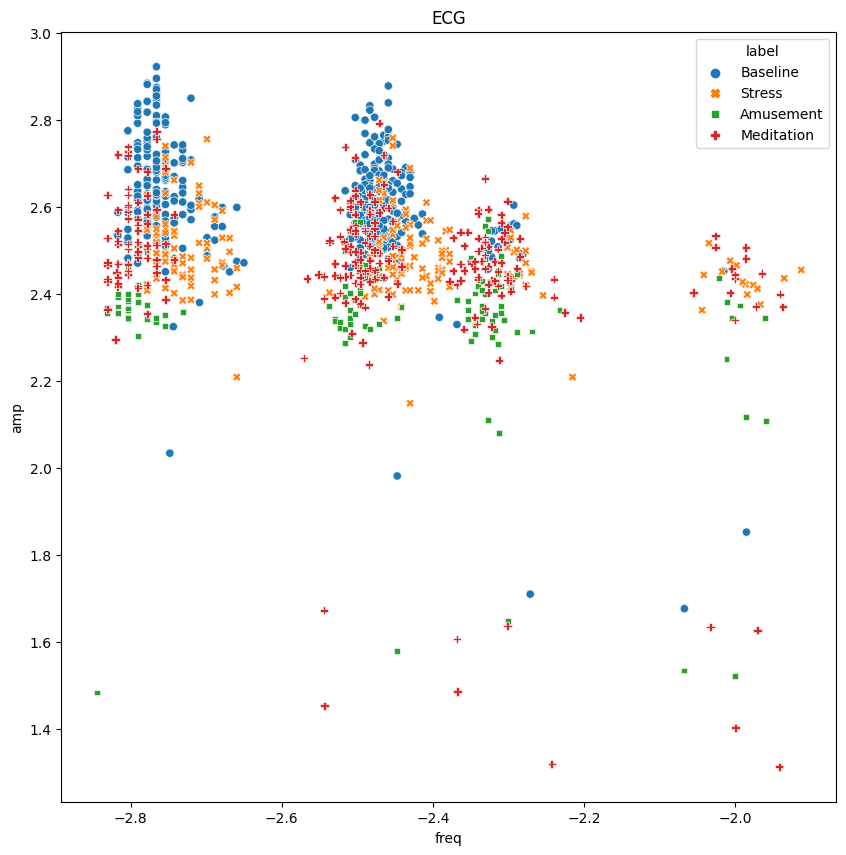

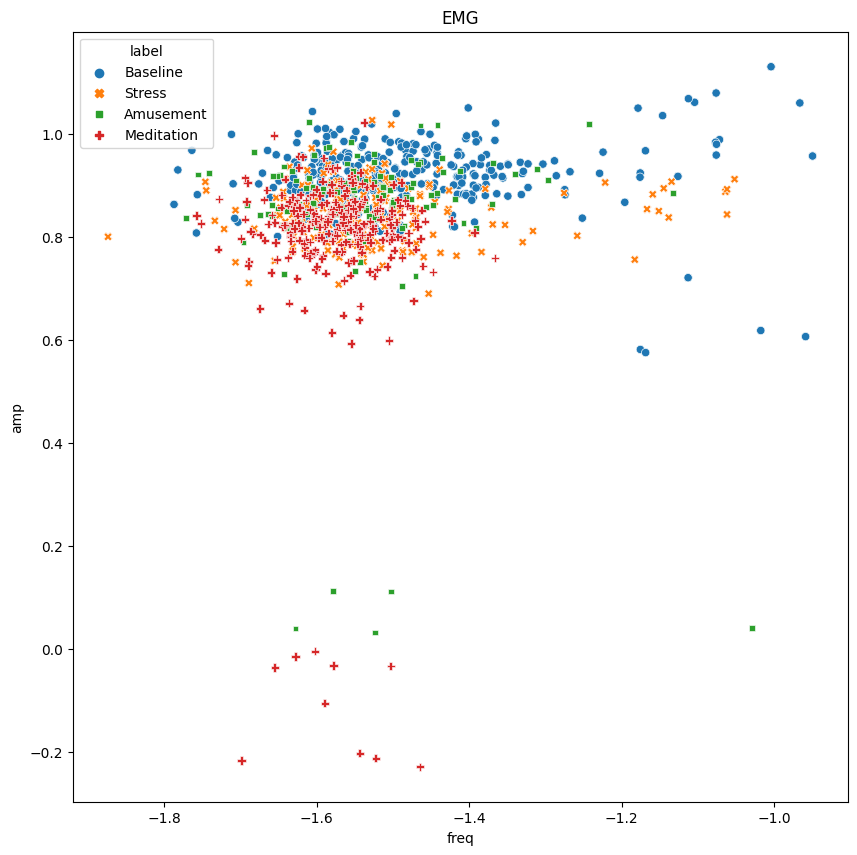

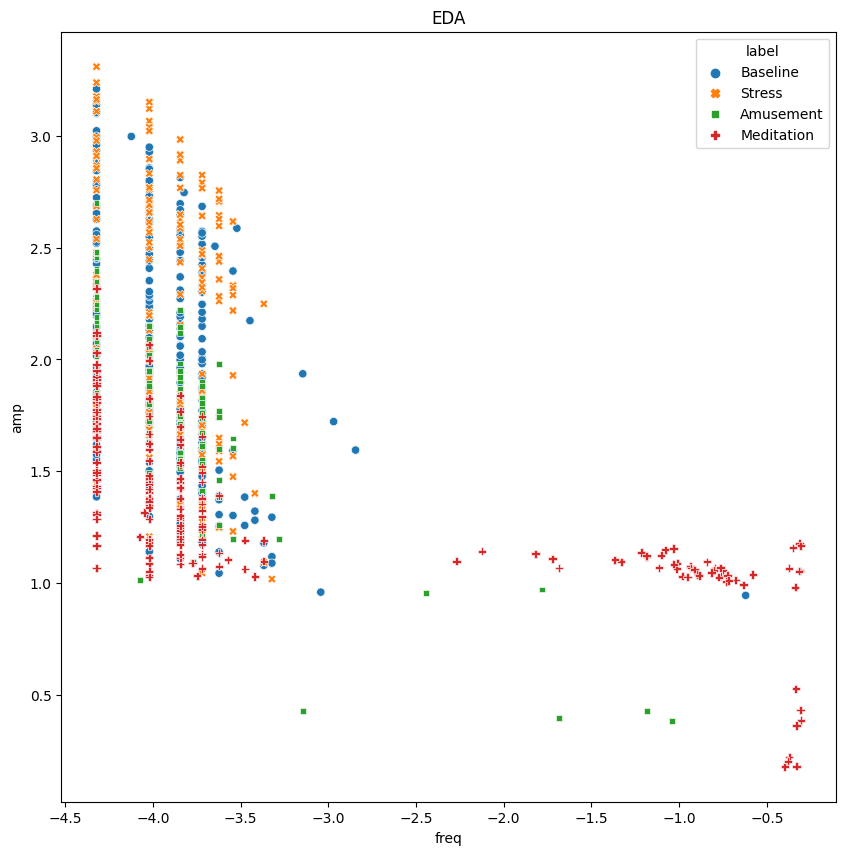

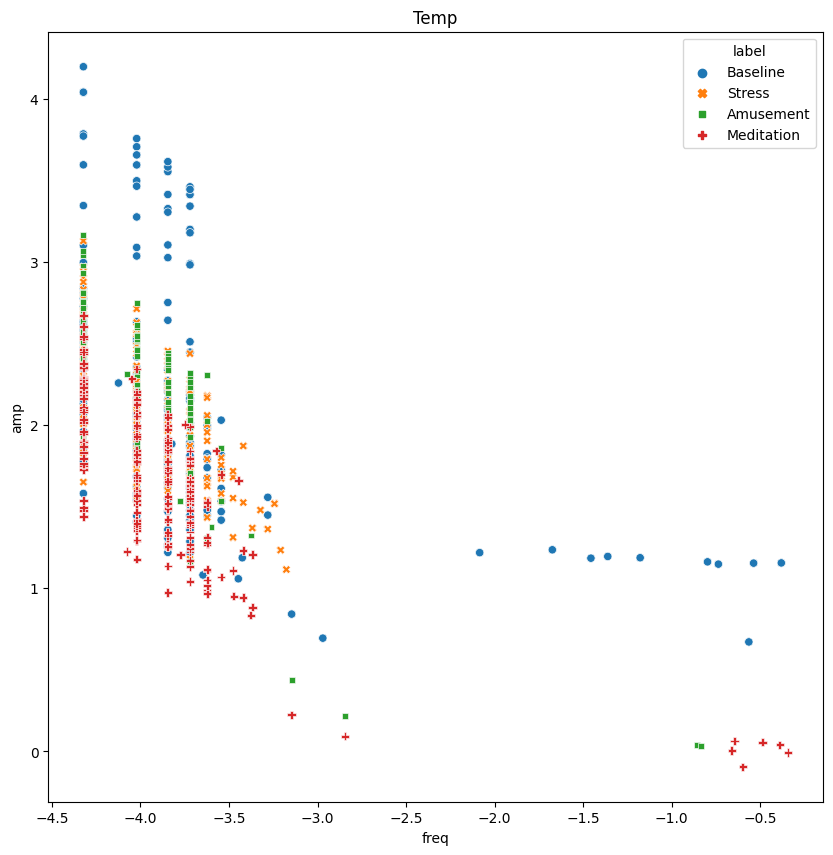

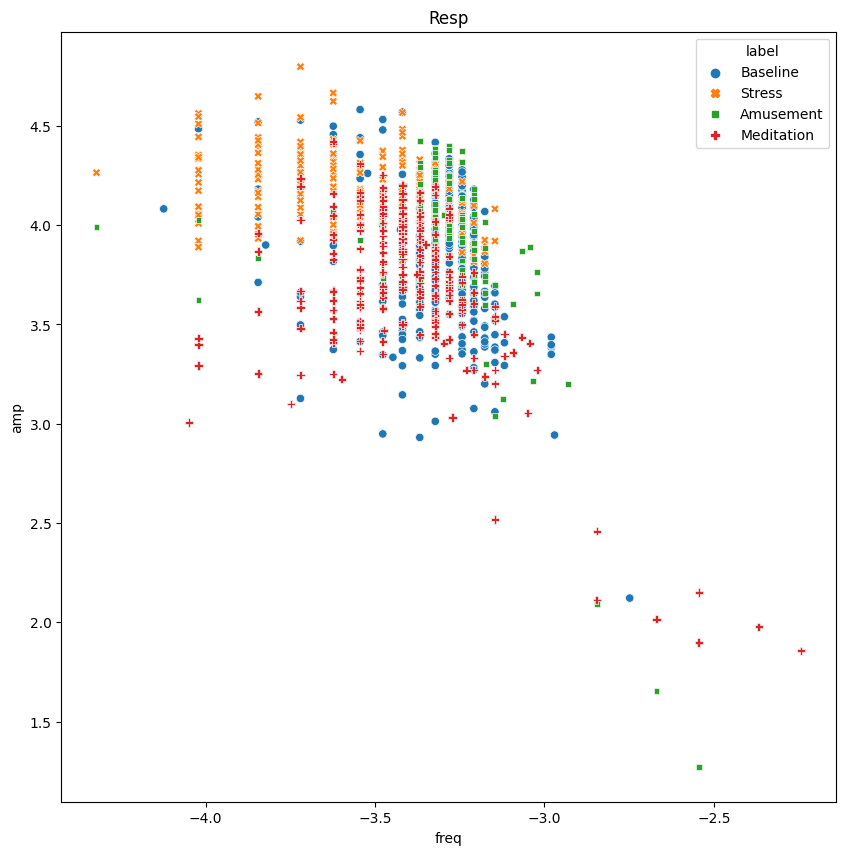

In [12]:
plt.style.use('default')


for signal_type in global_chest_signal_features :
    df = global_chest_signal_features[signal_type].copy()
    df[['amp', 'freq']] = np.log10(df[['amp', 'freq']])
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data = df, x = 'freq', y = 'amp', hue = 'label', style= 'label').set(title=signal_type)

In [13]:
from sklearn.naive_bayes import GaussianNB

In [19]:
df = global_chest_signal_features['ECG']
features = df[['amp', 'freq']].to_numpy()
labels = df['label'].to_numpy().flatten()

rev_ref = {v: k for k, v in ref.items()}
encoded_labels = np.vectorize(rev_ref.get)(labels)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [34]:
print(len(features))

14700


In [41]:
percent = 0.7
l = len(features)
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=13)

In [42]:
gnbmodel = GaussianNB()
gnbmodel.fit(features_train, labels_train)
gnbmodel.score(features_test, labels_test)

0.5452380952380952

In [43]:
lrmodel = LogisticRegression()
lrmodel.fit(features_train, labels_train)
lrmodel.score(features_test, labels_test)

0.5377551020408163

In [44]:
import tensorflow as tf
from tensorflow import keras

In [84]:
model = keras.Sequential([
    keras.layers.Dense(units=2,  activation='relu'),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=15, activation='relu'),
     keras.layers.Dense(units=15, activation='relu'),
    keras.layers.Dense(units=4, activation='relu')
])

In [80]:
he_ref = {
    1 : [1, 0, 0, 0],
    2 : [0, 1, 0, 0],
    3 : [0, 0, 1, 0],
    4 : [0, 0, 0, 1]
}

one_hot_encoded_labels = np.array([np.array(he_ref[x]) for x in encoded_labels])
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.3, random_state=13)

In [86]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [87]:
train_data = (features_train, labels_train)
test_data = (features_test, labels_test)

In [88]:
history = model.fit(
    features_train, labels_train, epochs=100
)

Epoch 1/100
322/322 [==============================] - 1s 866us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 2/100
322/322 [==============================] - 0s 875us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 3/100
322/322 [==============================] - 0s 878us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 4/100
322/322 [==============================] - 0s 854us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 5/100
322/322 [==============================] - 0s 852us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 6/100
322/322 [==============================] - 0s 853us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 7/100
322/322 [==============================] - 0s 846us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 8/100
322/322 [==============================] - 0s 835us/step - loss: 1.3863 - accuracy: 0.3910
Epoch 9/100
322/322 [==============================] - 0s 1ms/step - loss: 1.3863 - accuracy: 0.3910
Epoch 10/100
322/322 [==============================] - 0s 1ms/step - loss:

In [71]:
test_loss, test_acc = model.evaluate(features_test,  labels_test, verbose=2)

138/138 - 0s - loss: 1.1775 - accuracy: 0.4943


In [59]:
print(len(labels_train))

10290


In [61]:
print(len(features_train))

10290


In [66]:
features_train

array([[3.26712908e+02, 1.61904762e-03],
       [3.73533947e+02, 3.47619048e-03],
       [4.27386344e+02, 3.71428571e-03],
       ...,
       [3.51065838e+02, 4.80952381e-03],
       [3.93586160e+02, 4.71428571e-03],
       [4.29803780e+02, 1.71428571e-03]])